# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．

## MeCab実行

コマンドプロンプトで以下を実行

`mecab neko.txt -o neko.txt.mecab`

## 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [1]:
import os
from typing import List, Dict

In [2]:
input_path = os.path.join(os.getcwd(), '../data/neko.txt.mecab')

In [3]:
# 読み込み
def get_raw(path: str) -> str:
    with open(path, mode='r', encoding='utf-8') as f:
        return f.read()

In [4]:
# 文ごとにリストに入れる
def get_sentences(text: str) -> List[str]:
    return [s for s in text.split('EOS\n') if s != '']

test_text = """
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
　	記号,空白,*,*,*,*,　,　,　
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ
。	記号,句点,*,*,*,*,。,。,。
EOS
EOS
"""
get_sentences(test_text)

['\n一\t名詞,数,*,*,*,*,一,イチ,イチ\n',
 '\u3000\t記号,空白,*,*,*,*,\u3000,\u3000,\u3000\n吾輩\t名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ\nは\t助詞,係助詞,*,*,*,*,は,ハ,ワ\n猫\t名詞,一般,*,*,*,*,猫,ネコ,ネコ\nで\t助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ\nある\t助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル\n。\t記号,句点,*,*,*,*,。,。,。\n',
 '名前\t名詞,一般,*,*,*,*,名前,ナマエ,ナマエ\nは\t助詞,係助詞,*,*,*,*,は,ハ,ワ\nまだ\t副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ\n無い\t形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ\n。\t記号,句点,*,*,*,*,。,。,。\n']

In [5]:
# 文の形態素をマッピングし、リストに入れる
def mapping_sentence(text: str) -> List[Dict]:
    morphemes = text.split('\n')
    ret_list = []
    for m in morphemes:
        # 空白行は除外
        if m == '':
            continue
        # 表層系とそれ以外を分離
        surface, others = m.split('\t')
        # それ以外の中身を分離
        other = others.split(',')
        # 空白は除外
        if other[0] == '記号' and other[1] == '空白':
            continue
        # マッピング型にしてリストに追加
        ret_list.append({
            'surface': surface,
            'base': other[6],
            'pos': other[0],
            'pos1': other[1],
        })
    return ret_list

test_text = """
　	記号,空白,*,*,*,*,　,　,　
どこ	名詞,代名詞,一般,*,*,*,どこ,ドコ,ドコ
で	助詞,格助詞,一般,*,*,*,で,デ,デ
生れ	動詞,自立,*,*,一段,連用形,生れる,ウマレ,ウマレ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
か	助詞,副助詞／並立助詞／終助詞,*,*,*,*,か,カ,カ
とんと	副詞,一般,*,*,*,*,とんと,トント,トント
見当	名詞,サ変接続,*,*,*,*,見当,ケントウ,ケントー
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
つか	動詞,自立,*,*,五段・カ行イ音便,未然形,つく,ツカ,ツカ
ぬ	助動詞,*,*,*,特殊・ヌ,基本形,ぬ,ヌ,ヌ
。	記号,句点,*,*,*,*,。,。,。
"""

mapping_sentence(test_text)

[{'surface': 'どこ', 'base': 'どこ', 'pos': '名詞', 'pos1': '代名詞'},
 {'surface': 'で', 'base': 'で', 'pos': '助詞', 'pos1': '格助詞'},
 {'surface': '生れ', 'base': '生れる', 'pos': '動詞', 'pos1': '自立'},
 {'surface': 'た', 'base': 'た', 'pos': '助動詞', 'pos1': '*'},
 {'surface': 'か', 'base': 'か', 'pos': '助詞', 'pos1': '副助詞／並立助詞／終助詞'},
 {'surface': 'とんと', 'base': 'とんと', 'pos': '副詞', 'pos1': '一般'},
 {'surface': '見当', 'base': '見当', 'pos': '名詞', 'pos1': 'サ変接続'},
 {'surface': 'が', 'base': 'が', 'pos': '助詞', 'pos1': '格助詞'},
 {'surface': 'つか', 'base': 'つく', 'pos': '動詞', 'pos1': '自立'},
 {'surface': 'ぬ', 'base': 'ぬ', 'pos': '助動詞', 'pos1': '*'},
 {'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}]

In [6]:
# 形態素解析結果読み込み
def load_mecab(path: str) -> List[List[Dict]]:
    # 読み込み
    text = get_raw(input_path)
    # 文ごとに分離
    sentences = get_sentences(text)
    # マッピング型のリストに格納
    return list(map(mapping_sentence, sentences))

load_mecab(input_path)[0:2]

[[{'surface': '一', 'base': '一', 'pos': '名詞', 'pos1': '数'}],
 [{'surface': '吾輩', 'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞'},
  {'surface': 'は', 'base': 'は', 'pos': '助詞', 'pos1': '係助詞'},
  {'surface': '猫', 'base': '猫', 'pos': '名詞', 'pos1': '一般'},
  {'surface': 'で', 'base': 'だ', 'pos': '助動詞', 'pos1': '*'},
  {'surface': 'ある', 'base': 'ある', 'pos': '助動詞', 'pos1': '*'},
  {'surface': '。', 'base': '。', 'pos': '記号', 'pos1': '句点'}]]

## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [7]:
# 文に含まれる動詞の表層形をリストにする
def get_surface_of_verb(morphemes: List[Dict]) -> List[str]:
    return [m['surface'] for m in morphemes if m['pos'] == '動詞']

test_list = [
    {'surface': 'a', 'pos': '動詞'},
    {'surface': 'b', 'pos': '動詞'},
    {'surface': 'c', 'pos': '名詞'},
]
get_surface_of_verb(test_list) == ['a', 'b']

True

In [8]:
from functools import reduce

In [9]:
# 各文から取り出して、和集合をとる
output = reduce(lambda x, y: set(x) | set(y),
                map(get_surface_of_verb, load_mecab(input_path))
)
# print(output)

## 32. 動詞の原形
動詞の原形をすべて抽出せよ．

In [10]:
# 文に含まれる動詞の原型をリストにする
def get_base_of_verb(morphemes: List[Dict]) -> List[str]:
    return [m['base'] for m in morphemes if m['pos'] == '動詞']

test_list = [
    {'base': 'a', 'pos': '動詞'},
    {'base': 'b', 'pos': '動詞'},
    {'base': 'c', 'pos': '名詞'},
]
get_base_of_verb(test_list) == ['a', 'b']

True

In [11]:
# 各文から取り出して、和集合をとる
output = reduce(lambda x, y: set(x) | set(y),
                map(get_base_of_verb, load_mecab(input_path))
)
# print(output)

## 33. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [12]:
# 名詞句を抽出する
def get_noun_phrase(morphemes: List[Dict]) -> List[str]:
    ret_list = []
    for i in range(len(morphemes) - 2):
        m1 = morphemes[i]
        # 名詞でなかったらパス
        if m1['pos'] != '名詞':
            continue
        # 'の'が挟まってなかったらパス
        m2 = morphemes[i+1]
        if m2['surface'] != 'の':
            continue
        # 名詞で挟んでなかったらパス
        m3 = morphemes[i+2]
        if  m3['pos'] != '名詞':
            continue
        # (名詞)'の'(名詞)だったらリストに追加
        ret_list.append(m1['surface'] + m2['surface'] + m3['surface'])
    return ret_list

test_list = [
    {'surface': 'a', 'pos': '名詞'},
    {'surface': 'b', 'pos': '名詞'},
    {'surface': 'の', 'pos': ''},
    {'surface': 'c', 'pos': '名詞'},
    {'surface': 'の', 'pos': ''},
    {'surface': 'd', 'pos': '名詞'},
    {'surface': 'の', 'pos': ''},
    {'surface': 'e', 'pos': '動詞'},
]
get_noun_phrase(test_list) == ['bのc', 'cのd']

True

In [13]:
# 各文から取り出して、和集合をとる
output = reduce(lambda x, y: set(x) | set(y),
                map(get_noun_phrase, load_mecab(input_path))
)
# print(output)

## 34. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [14]:
# 名詞の連接（連続して出現する名詞）を抽出
def get_noun_articulation(morphemes: List[Dict]) -> List[str]:
    ret_list = []
    temp = []
    for m in morphemes:
        # 名詞だったらストック
        if m['pos'] == '名詞':
            temp.append(m['surface'])
        # 名詞でなかったらリセット
        else:
            # 名詞が2つ以上連続していたら、抽出
            if len(temp) >=2:
                ret_list.append(''.join(temp))
            temp = []
    # ループ終了時のチェック
    # 2つ以上連続していたら、抽出
    if len(temp) >=2:
        ret_list.append(''.join(temp))
    return ret_list

test_list = [
    {'surface': 'a', 'pos': '名詞'},
    {'surface': 'b', 'pos': '動詞'},
    {'surface': 'c', 'pos': '名詞'},
    {'surface': 'd', 'pos': '名詞'},
    {'surface': 'e', 'pos': '動詞'},
    {'surface': 'f', 'pos': '名詞'},
    {'surface': 'g', 'pos': '名詞'},
    {'surface': 'h', 'pos': '名詞'},
    {'surface': 'i', 'pos': '動詞'},
]
get_noun_articulation(test_list) == ['cd', 'fgh']

True

In [15]:
# 各文から取り出して、和集合をとる
output = reduce(lambda x, y: set(x) | set(y),
                map(get_noun_articulation, load_mecab(input_path))
)
# print(output)

## 35. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [38]:
# '助詞'と'記号'以外に絞る
def get_word(morphemes: List[Dict]) -> List[Dict]:
    ret_list = []
    for m in morphemes:
        if m['pos'] != '助詞' and m['pos'] != '記号':
            ret_list.append(m)
    return ret_list

test_list = [
    {'surface': 'a', 'pos': '名詞'},
    {'surface': 'b', 'pos': '助詞'},
    {'surface': 'c', 'pos': '記号'},
]
get_word(test_list) == [{'surface': 'a', 'pos': '名詞'}]

True

In [16]:
import pandas as pd

In [45]:
# 単語一覧
words = reduce(
    lambda x, y: x+y,
    map(lambda morphemes: [m['base'] for m in morphemes],
        map(get_word, load_mecab(input_path))
       )
)
# Pandas DataFrameを使って集計、ソート
df_word_cnt = (
    pd.DataFrame({'word': words})
    .assign(cnt=1) # カウント列追加
    .groupby('word')['cnt'].count()
    .sort_values(ascending=False)
)
df_word_cnt

word
だ        5975
た        4267
する       3657
ない       3052
ある       2320
         ... 
振り落とす       1
振れる         1
振袖          1
挽回          1
愁然          1
Name: cnt, Length: 11140, dtype: int64

## 36. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

In [46]:
# 出現頻度が高い10語
df_word_cnt.head(10)

word
だ     5975
た     4267
する    3657
ない    3052
ある    2320
*     2191
いる    1777
の     1611
ん     1554
云う    1408
Name: cnt, dtype: int64

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

<BarContainer object of 10 artists>

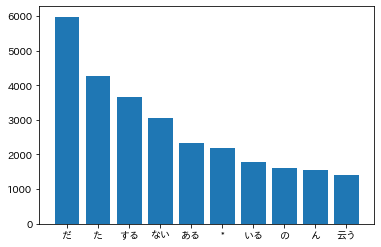

In [48]:
# 出現頻度をグラフ表示
fig, ax = plt.subplots(1, 1)
x = df_word_cnt.head(10).index
y = df_word_cnt.head(10).values
ax.bar(x=x, height=y)

## 37. 「猫」と共起頻度の高い上位10語
「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

In [49]:
# ある単語を含む文のみ抽出
def get_sentence_with_word(sentences: List[List[Dict]], word: str) -> List[List[Dict]]:
    ret_list = []
    for morphemes in sentences:
        for m in morphemes:
            # 猫が居たらストック
            if m['surface'] == word:
                ret_list.append(morphemes)
                break
    return ret_list

test_list = [
    [{'surface': '猫', 'pos': '名詞'},
    {'surface': 'b', 'pos': '動詞'}],
    [{'surface': 'i', 'pos': '動詞'}],
    [{'surface': '猫', 'pos': '動詞'}],
]
get_sentence_with_word(test_list, word='猫') == [
    [{'surface': '猫', 'pos': '名詞'},
    {'surface': 'b', 'pos': '動詞'}],
    [{'surface': '猫', 'pos': '動詞'}],
]

True

In [52]:
# 猫を含む文の単語一覧
neko_words = reduce(
    lambda x, y: x+y,
    map(lambda morphemes: [m['base'] for m in morphemes],
                map(get_word,
                    get_sentence_with_word(load_mecab(input_path), word='猫')
                   )
       )
)
# Pandas DataFrameを使って集計、ソート
df_neko_word_cnt = (
    pd.DataFrame({'word': neko_words})
    .assign(cnt=1) # カウント列追加
    .groupby('word')['cnt'].count()
    .sort_values(ascending=False)
)
df_neko_word_cnt

word
猫     248
だ     231
する    144
た     140
ある    127
     ... 
極り      1
極度      1
楽       1
構う      1
忠告      1
Name: cnt, Length: 1544, dtype: int64

In [53]:
# 猫も入ってるので、11個表示させておく
df_neko_word_cnt.head(11)

word
猫     248
だ     231
する    144
た     140
ある    127
ない    112
*      63
事      59
いる     58
吾輩     58
の      55
Name: cnt, dtype: int64

<BarContainer object of 10 artists>

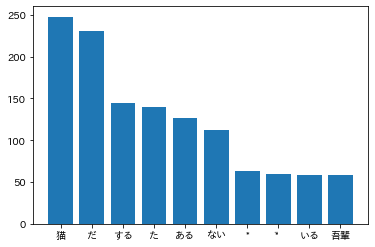

In [54]:
# 出現頻度をグラフ表示
fig, ax = plt.subplots(1, 1)
x = df_neko_word_cnt.head(10).index
y = df_neko_word_cnt.head(10).values
ax.bar(x=x, height=y)

## 38. ヒストグラム
単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．

In [22]:
# load_mecab(input_path)